In [1]:
# !pip install "git+ssh://git@github.com/MindSetLib/MS-InsuranceScoring.git@InsolverPackage#egg=insolver"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import hp

In [3]:
from insolver.InsolverDataFrame import InsolverDataFrame
from insolver.InsolverTransforms import (
    TransformExp,
    InsolverTransformMain,
    InsolverTransforms,
    TransformAge,
    TransformMapValues,
    TransformPolynomizer,
    TransformAgeGender,
)
from insolver.InsolverWrapperGBM import InsolverGradientBoostingWrapper
from insolver.InsolverPlotsGBM import PredictionPlots, ShapPlots
from insolver.InsolverWrapperGLM import InsolverGLMWrapper
from insolver.InsolverUtils import train_val_test_split

In [4]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [5]:
InsDataFrame = InsolverDataFrame(df)

In [6]:
InsDataFrame.head(7)

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,ClaimInd,Dataset,DeducType,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.499,230,2004-07-01,NaN,3,Male,Other,CSP47,Professional,53,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.218,169,2004-01-01,2004-03-20,6-7,Male,Other,CSP50,Private+trip to office,32,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
InsDataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343080 entries, 0 to 343079
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           343080 non-null  float64
 1   LicAge             343080 non-null  int64  
 2   RecordBeg          343080 non-null  object 
 3   RecordEnd          181115 non-null  object 
 4   VehAge             177880 non-null  object 
 5   Gender             343080 non-null  object 
 6   MariStat           343080 non-null  object 
 7   SocioCateg         343080 non-null  object 
 8   VehUsage           343080 non-null  object 
 9   DrivAge            343080 non-null  int64  
 10  HasKmLimit         343080 non-null  int64  
 11  BonusMalus         343080 non-null  int64  
 12  VehBody            145780 non-null  object 
 13  VehPrice           145780 non-null  object 
 14  VehEngine          145780 non-null  object 
 15  VehEnergy          145780 non-null  object 
 16  Ve

In [8]:
InsDataFrame.get_meta_info()

{'type': 'InsolverDataFrame',
 'len': 343080,
 'columns': [{'name': 'Exposure', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'LicAge', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'RecordBeg', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'RecordEnd', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehAge', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'Gender', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'MariStat', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'SocioCateg', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehUsage', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'DrivAge', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'HasKmLimit', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'BonusMalus', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'VehBody', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehPrice', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehEngine', 'dtype': dtype(

In [9]:
@staticmethod
def exp_new(exp, exp_max):
    if pd.isnull(exp):
        exp = None
    elif exp < 0:
        exp = None
    else:
        exp = exp * 7 // 365
    if exp > exp_max:
        exp = exp_max
    return exp

TransformExp._exp = exp_new

In [10]:
class TransformSocioCateg(InsolverTransformMain):
    def __init__(self, column_socio_categ):
        self.priority = 0
        super().__init__()
        self.column_socio_categ = column_socio_categ

    def __call__(self, df):
        df[self.column_socio_categ] = df[self.column_socio_categ].str.slice(0,4)
        return df

In [11]:
class TransformToNumeric(InsolverTransformMain):
    def __init__(self, column_param, downcast='integer'):
        self.priority = 0
        super().__init__()
        self.column_param = column_param
        self.downcast = downcast

    def __call__(self, df):
        df[self.column_param] = pd.to_numeric(df[self.column_param], downcast=self.downcast)
        return df

In [12]:
InsTransforms = InsolverTransforms(InsDataFrame.get_data(), [
    TransformAge('DrivAge', 18, 75),
    TransformExp('LicAge', 57),
    TransformMapValues('Gender', {'Male':0, 'Female':1}),
    TransformMapValues('MariStat', {'Other':0, 'Alone':1}),
    TransformSocioCateg('SocioCateg'),
    TransformAgeGender('DrivAge', 'Gender', 'Age_m', 'Age_f', age_default=18, gender_male=0, gender_female=1),
    TransformPolynomizer('Age_m'),
    TransformPolynomizer('Age_f'),
    # TransformToNumeric('VehAge'),
    # T.TransformVehAge('VehAge', 20),
    ])

In [13]:
InsTransforms.transforms

In [14]:
InsTransforms.transform()

{'TransformSocioCateg': {'column_socio_categ': 'SocioCateg', 'priority': 0},
 'TransformAge': {'age_max': 75,
  'age_min': 18,
  'column_driver_minage': 'DrivAge',
  'priority': 1},
 'TransformExp': {'column_driver_minexp': 'LicAge',
  'exp_max': 57,
  'priority': 1},
 'TransformMapValues': {'column_param': 'MariStat',
  'dictionary': {'Other': 0, 'Alone': 1},
  'priority': 1},
 'TransformAgeGender': {'age_default': 18,
  'column_age': 'DrivAge',
  'column_age_f': 'Age_f',
  'column_age_m': 'Age_m',
  'column_gender': 'Gender',
  'gender_female': 1,
  'gender_male': 0,
  'priority': 2},
 'TransformPolynomizer': {'column_param': 'Age_f', 'n': 2, 'priority': 3}}

In [15]:
InsTransforms.head(7)

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea,Age_m,Age_f,Age_m_2,Age_f_2
0,0.583,7,2004-06-01,NaN,2,1,0,CSP1,Professional,55,...,NaN,NaN,NaN,NaN,NaN,NaN,18,55,324,3025
1,0.200,3,2004-10-19,NaN,0,0,1,CSP5,Private+trip to office,34,...,NaN,NaN,NaN,NaN,NaN,NaN,34,18,1156,324
2,0.083,3,2004-07-16,2004-08-16,1,1,0,CSP1,Professional,33,...,NaN,NaN,NaN,NaN,NaN,NaN,18,33,324,1089
3,0.375,3,2004-08-16,NaN,1,1,0,CSP1,Professional,34,...,NaN,NaN,NaN,NaN,NaN,NaN,18,34,324,1156
4,0.500,4,2004-01-01,2004-07-01,3,0,0,CSP4,Professional,53,...,NaN,NaN,NaN,NaN,NaN,NaN,53,18,2809,324
5,0.499,4,2004-07-01,NaN,3,0,0,CSP4,Professional,53,...,NaN,NaN,NaN,NaN,NaN,NaN,53,18,2809,324
6,0.218,3,2004-01-01,2004-03-20,6-7,0,0,CSP5,Private+trip to office,32,...,NaN,NaN,NaN,NaN,NaN,NaN,32,18,1024,324


In [16]:
InsTransforms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343080 entries, 0 to 343079
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           343080 non-null  float64
 1   LicAge             343080 non-null  int64  
 2   RecordBeg          343080 non-null  object 
 3   RecordEnd          181115 non-null  object 
 4   VehAge             177880 non-null  object 
 5   Gender             343080 non-null  int64  
 6   MariStat           343080 non-null  int64  
 7   SocioCateg         343080 non-null  object 
 8   VehUsage           343080 non-null  object 
 9   DrivAge            343080 non-null  int64  
 10  HasKmLimit         343080 non-null  int64  
 11  BonusMalus         343080 non-null  int64  
 12  VehBody            145780 non-null  object 
 13  VehPrice           145780 non-null  object 
 14  VehEngine          145780 non-null  object 
 15  VehEnergy          145780 non-null  object 
 16  Ve

In [17]:
InsTransforms.get_meta_info()

{'type': 'InsolverDataFrame',
 'len': 343080,
 'columns': [{'name': 'Exposure', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'LicAge', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'RecordBeg', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'RecordEnd', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehAge', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'Gender', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'MariStat', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'SocioCateg', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehUsage', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'DrivAge', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'HasKmLimit', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'BonusMalus', 'dtype': dtype('int64'), 'use': 'unknown'},
  {'name': 'VehBody', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehPrice', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'VehEngine', 'dtype'

In [18]:
df = InsTransforms.get_data()

In [19]:
df = df[df.Dataset.isin([5,6,7,8,9])]
df.dropna(how='all', axis=1, inplace=True)
df = df[df.ClaimAmount > 0]

In [20]:
features = ['LicAge', 'Gender', 'MariStat', 'DrivAge', 'HasKmLimit', 'BonusMalus', 'RiskArea',
            'Age_m', 'Age_f', 'Age_m_2', 'Age_f_2']
target = 'ClaimAmount'

In [21]:
x_train, x_valid, x_test, \
y_train, y_valid, y_test = train_val_test_split(df[features], df[target], val_size=0.7, test_size=0.15)

In [22]:
iglm = InsolverGLMWrapper()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,50 mins 32 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_Thinkpad_2kk3yw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,65.0 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [23]:
train = pd.concat([x_train, y_train], axis=1)
valid = pd.concat([x_valid, y_valid], axis=1)
test = pd.concat([x_test, y_test], axis=1)

In [24]:
train, valid = iglm.model_init(train, valid, family='gamma', link='log')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
params = {'lambda': [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0],
          'alpha': [i * 0.1 for i in range(0, 11)]}

In [26]:
iglm.grid_search_cv(features, target, train, valid, params, search_criteria={'strategy': "Cartesian"})
# iglm.fit(features, target, train, valid)
print(iglm.best_params)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_9e9697cfaa17f3bac29bd926f14f4d5f.hex_model_python_1600070493170_8_model_1


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gamma,log,Ridge ( lambda = 1.0 ),11,11,3,Key_Frame__upload_9e9697cfaa17f3bac29bd926f14f4d5f.hex




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 13735213.141869817
RMSE: 3706.104847662815
MAE: 1795.8793147649224
RMSLE: 1.5628947130844195
R^2: 0.01457406423878671
Mean Residual Deviance: 1.6642903006387817
Null degrees of freedom: 2328
Residual degrees of freedom: 2317
Null deviance: 3987.6133809650883
Residual deviance: 3876.1321101877224
AIC: NaN

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 144870624.3554228
RMSE: 12036.221348721649
MAE: 2124.914188310581
RMSLE: 1.612500773740454
R^2: 5.9971870337571787e-05
Mean Residual Deviance: 2.0284807380712304
Null degrees of freedom: 10872
Residual degrees of freedom: 10861
Null deviance: 22297.880678829966
Residual deviance: 22055.67106504849
AIC: NaN

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2020-09-14 11:52:31,0.000 sec,0,3987.613385,1.712157,,,,,,,,
1,,2020-09-14 11:52:31,0.004 sec,1,3874.652963,1.671770,,,,,,,,
2,,2020-09-14 11:52:31,0.015 sec,2,3876.129378,1.671580,,,,,,,,
3,,2020-09-14 11:52:31,0.024 sec,3,3876.132113,1.671580,3706.1,1.66429,1795.88,0.0145741,12036.2,2.02848,2124.91,5.99719e-05


In [27]:
predict_glm = iglm.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [28]:
iglm.save_model('glm')

In [29]:
igbm = InsolverGradientBoostingWrapper(algorithm='xgboost', task='regression')

In [30]:
space_xgboost = {"objective": 'reg:gamma',
                 "max_depth": hp.choice('max_depth', [5, 8, 10, 12, 15]),
                 "min_child_weight": hp.uniform('min_child_weight', 0, 50),
                 "subsample": hp.uniform('subsample', 0.5, 1),
                 "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1),
                 "alpha": hp.uniform('alpha', 0, 1),
                 "lambda": hp.uniform('lambda', 0, 1),
                 "eta": hp.uniform('eta', 0.01, 1),
                 "gamma": hp.uniform('gamma', 0.01, 1000),
                 "tree_method": 'hist'}

In [31]:
cv_par = {'num_boost_round': 250,
          'nfold': 3,
          'early_stopping_rounds': 20,
          'seed': 0,
          'shuffle': True,
          'stratified': False}

In [32]:
igbm.hyperopt_cv(x_train, y_train, space_xgboost, cv_par, max_evals=250)

100%|██████████████| 250/250 [01:37<00:00,  2.56trial/s, best loss: 8.537328333333333]


In [33]:
igbm.model_init()

In [34]:
igbm.fit(x_train, y_train)

[12:00:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [35]:
predict_gbm1 = igbm.predict(x_test)

In [36]:
igbm.fit_booster(x_train, y_train, core_params={'evals': [((x_train, y_train), 'train'),
                                                          ((x_valid, y_valid), 'valid')],
                                                'verbose_eval': False})

In [37]:
predict_gbm2 = igbm.predict_booster(x_test)

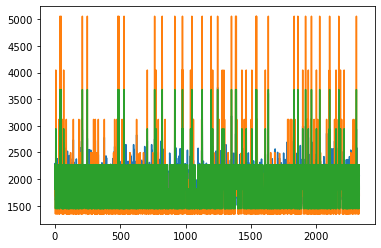

In [38]:
plt.plot(predict_glm)
plt.plot(predict_gbm1)
plt.plot(predict_gbm2)
plt.show()